Using cache found in C:\Users\karol/.cache\torch\hub\pytorch_vision_v0.13.1
Using cache found in C:\Users\karol/.cache\torch\hub\pytorch_vision_v0.10.0


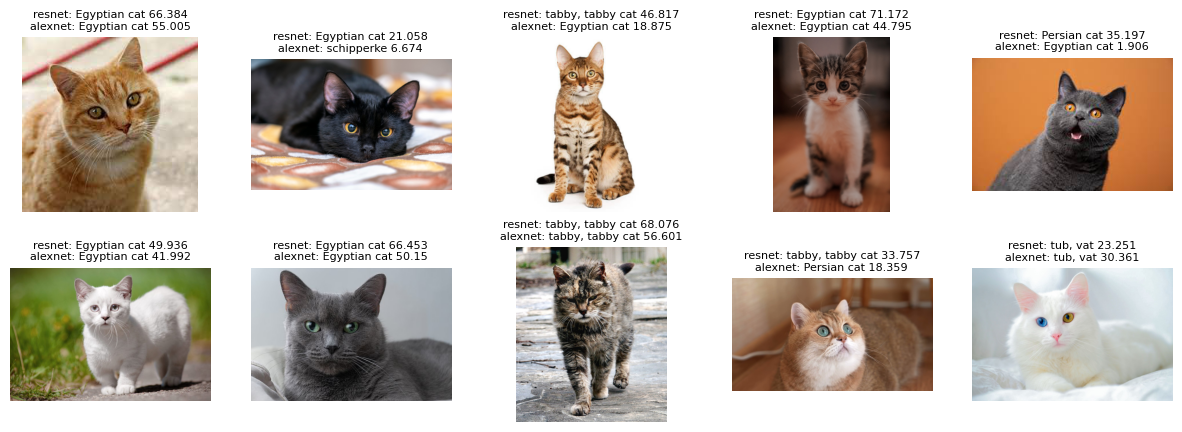

In [29]:
# Aufgabe 1
import torch
from torch import hub

resnet = hub.load('pytorch/vision:v0.13.1','resnet18',pretrained=True)
alexnet = hub.load('pytorch/vision:v0.10.0','alexnet',pretrained=True)
resnet.eval()
alexnet.eval()

from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms
preprocess = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

cat = [Image.open('cat_1.jpg'),Image.open('cat_2.jpg'),Image.open('cat_3.jpg'),Image.open('cat_4.jpg'),Image.open('cat_5.jpg'),Image.open('cat_6.jpg'),Image.open('cat_7.jpg'),Image.open('cat_8.jpg'),Image.open('cat_9.jpg'),Image.open('cat_10.jpg')]
f, axarr = plt.subplots(2,5, figsize=(15, 5))
j = 0
u = 0
for i in range (0,10):

    img = preprocess(cat[i])
    batch_t = torch.unsqueeze(img,0)
    out = resnet(batch_t)
    out2 = alexnet(batch_t)
    
    _, index = torch.max(out, 1)
    _, index2 = torch.max(out2, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    percentage2 = torch.nn.functional.softmax(out2, dim=1)[0] * 100
    x,y = labels[index[0]], percentage[index[0]].item()
    x2,y2 = labels[index2[0]], percentage2[index[0]].item()
    y = round(y,3)
    y2= round(y2,3)
    axarr[u,j].imshow(cat[i])
    axarr[u,j].axis('off')
    k = "resnet: "+x+" "+str(y)+"\n"+"alexnet: "+x2+" "+str(y2)
    axarr[u,j].set_title(k, fontsize=8)
    j = j+1
    if i == 4:
        j = 0
        u = 1

In [28]:
# Aufgabe 2
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)
    

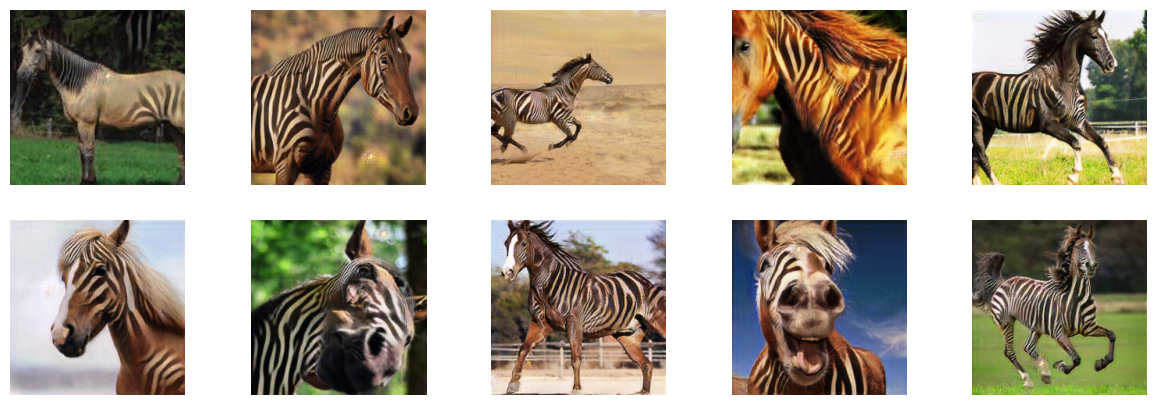

In [26]:
netG = ResNetGenerator()

model_path = 'horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)
netG.eval()

from PIL import Image
from torchvision import transforms

horse = [Image.open('horse_1.jpg'),Image.open('horse_2.jpg'),Image.open('horse_3.jpg'),Image.open('horse_4.jpg'),Image.open('horse_5.jpg'),Image.open('horse_6.jpg'),Image.open('horse_7.jpg'),Image.open('horse_8.jpg'),Image.open('horse_9.jpg'),Image.open('horse_10.jpg')]
f, axarr = plt.subplots(2,5, figsize=(15, 5))
j = 0
u = 0
for i in range (0,10):

    img = preprocess(horse[i])
    batch_t = torch.unsqueeze(img,0)
    batch_out = netG(batch_t)
    out_t = (batch_out.data.squeeze() + 1.0) / 2.0
    out_img = transforms.ToPILImage()(out_t)
    
    axarr[u,j].imshow(out_img)
    axarr[u,j].axis('off')
    j = j+1
    if i == 4:
        j = 0
        u = 1